In [6]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

X shape: (1000, 2)
y shape: (1000,)
Unique classes: [0 1 2 3 4]


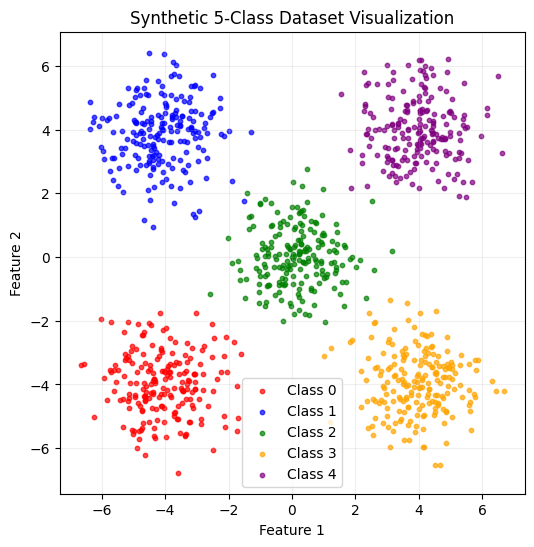

In [7]:
def generate_synthetic_data(num_samples_per_class=200, num_classes=5, num_features=2):
    total_samples = num_samples_per_class * num_classes
    X = np.zeros((total_samples, num_features))
    y = np.zeros(total_samples, dtype=int)

    centers = [(-4,-4), (-4,4), (0,0), (4,-4), (4,4)]
    centers = centers[:num_classes]

    idx = 0
    for class_id, (cx, cy) in enumerate(centers):
        samples = np.random.randn(num_samples_per_class, num_features)
        samples[:,0] += cx
        samples[:,1] += cy
        X[idx:idx+num_samples_per_class] = samples
        y[idx:idx+num_samples_per_class] = class_id
        idx += num_samples_per_class

    perm = np.random.permutation(total_samples)
    X = X[perm]
    y = y[perm]
    return X, y

X, y = generate_synthetic_data(num_samples_per_class=200, num_classes=5, num_features=2)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique classes:", np.unique(y))

colors = ['red', 'blue', 'green', 'orange', 'purple']
plt.figure(figsize=(6,6))
for class_id in range(5):
    mask = (y == class_id)
    plt.scatter(X[mask, 0], X[mask, 1], s=10, alpha=0.7, c=colors[class_id], label=f"Class {class_id}")
plt.title("Synthetic 5-Class Dataset Visualization")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

In [8]:
def train_test_split_numpy(X, y, test_ratio=0.2):
    N = X.shape[0]
    test_size = int(N * test_ratio)
    X_train = X[:-test_size]
    y_train = y[:-test_size]
    X_test  = X[-test_size:]
    y_test  = y[-test_size:]
    return X_train, X_test, y_train, y_test

def one_hot_encode(y, num_classes):
    N = y.shape[0]
    y_oh = np.zeros((N, num_classes))
    for i in range(N):
        y_oh[i, y[i]] = 1.0
    return y_oh

num_classes = 5
X_train, X_test, y_train, y_test = train_test_split_numpy(X, y, test_ratio=0.2)

mean = X_train.mean(axis=0, keepdims=True)
std  = X_train.std(axis=0, keepdims=True) + 1e-8
X_train_norm = (X_train - mean) / std
X_test_norm  = (X_test  - mean) / std

Y_train_oh = one_hot_encode(y_train, num_classes)
Y_test_oh  = one_hot_encode(y_test, num_classes)

print("Train X:", X_train_norm.shape, "Train Y one-hot:", Y_train_oh.shape)
print("Test  X:", X_test_norm.shape,  "Test  Y one-hot:", Y_test_oh.shape)


Train X: (800, 2) Train Y one-hot: (800, 5)
Test  X: (200, 2) Test  Y one-hot: (200, 5)


In [9]:
class ThreeHiddenLayerNN:
    def __init__(self, input_dim, h1, h2, h3, output_dim, learning_rate=0.1):
        self.lr = learning_rate
        self.W_IH1  = np.random.randn(input_dim, h1) / np.sqrt(input_dim)
        self.W_H1H2 = np.random.randn(h1, h2) / np.sqrt(h1)
        self.W_H2H3 = np.random.randn(h2, h3) / np.sqrt(h2)
        self.W_H3O  = np.random.randn(h3, output_dim) / np.sqrt(h3)
        self.b1 = np.zeros((1,h1))
        self.b2 = np.zeros((1,h2))
        self.b3 = np.zeros((1,h3))
        self.b4 = np.zeros((1,output_dim))

    def sigmoid(self, x):
        x = np.clip(x, -500, 500)
        return 1.0 / (1.0 + np.exp(-x))

    def sigmoid_deriv_from_output(self, sig_out):
        return sig_out * (1 - sig_out)

    def softmax(self, x):
        x_shift = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x_shift)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def feedForward(self, X):
        self.z1 = np.dot(X, self.W_IH1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W_H1H2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W_H2H3) + self.b3
        self.a3 = self.sigmoid(self.z3)
        self.z4 = np.dot(self.a3, self.W_H3O) + self.b4
        self.a4 = self.softmax(self.z4)
        return self.a4

    def cross_entropy(self, Y_true, Y_pred):
        eps = 1e-8
        Y_pred_clipped = np.clip(Y_pred, eps, 1 - eps)
        ce = -np.sum(Y_true * np.log(Y_pred_clipped), axis=1)
        return np.mean(ce)

    def backPropagation(self, X, Y_true, Y_pred):
        N = X.shape[0]
        dZ4 = (Y_pred - Y_true)/N
        dW_H3O = np.dot(self.a3.T, dZ4)
        db4 = np.sum(dZ4, axis=0, keepdims=True)

        dA3 = np.dot(dZ4, self.W_H3O.T)
        dZ3 = dA3 * self.sigmoid_deriv_from_output(self.a3)
        dW_H2H3 = np.dot(self.a2.T, dZ3)
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        dA2 = np.dot(dZ3, self.W_H2H3.T)
        dZ2 = dA2 * self.sigmoid_deriv_from_output(self.a2)
        dW_H1H2 = np.dot(self.a1.T, dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = np.dot(dZ2, self.W_H1H2.T)
        dZ1 = dA1 * self.sigmoid_deriv_from_output(self.a1)
        dW_IH1 = np.dot(X.T, dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        self.W_H3O -= self.lr * dW_H3O
        self.b4    -= self.lr * db4
        self.W_H2H3 -= self.lr * dW_H2H3
        self.b3    -= self.lr * db3
        self.W_H1H2 -= self.lr * dW_H1H2
        self.b2    -= self.lr * db2
        self.W_IH1 -= self.lr * dW_IH1
        self.b1    -= self.lr * db1

    def train_step(self, X, Y_true):
        Y_pred = self.feedForward(X)
        loss = self.cross_entropy(Y_true, Y_pred)
        self.backPropagation(X, Y_true, Y_pred)
        return loss

    def predict_proba(self, X):
        return self.feedForward(X)

    def predict_class(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [10]:
input_dim = X_train_norm.shape[1]
h1, h2, h3 = 16, 12, 8
output_dim = num_classes

model = ThreeHiddenLayerNN(input_dim, h1, h2, h3, output_dim, learning_rate=0.15)

num_epochs = 4000
train_losses, test_losses = [], []
train_accs, test_accs = [], []

def accuracy_score_np(y_true, y_pred):
    return np.mean(y_true == y_pred)

for epoch in range(num_epochs):
    loss_train = model.train_step(X_train_norm, Y_train_oh)
    train_losses.append(loss_train)

    probs_test = model.predict_proba(X_test_norm)
    loss_test = model.cross_entropy(Y_test_oh, probs_test)
    test_losses.append(loss_test)

    pred_train = model.predict_class(X_train_norm)
    pred_test  = model.predict_class(X_test_norm)
    acc_train = accuracy_score_np(y_train, pred_train)
    acc_test  = accuracy_score_np(y_test, pred_test)
    train_accs.append(acc_train)
    test_accs.append(acc_test)

    if epoch % 400 == 0:
        print(f"Epoch {epoch:4d} | Train Loss = {loss_train:.4f}, "
              f"Test Loss = {loss_test:.4f}, "
              f"Train Acc = {acc_train:.3f}, Test Acc = {acc_test:.3f}")

print("Training finished!")

Epoch    0 | Train Loss = 1.6386, Test Loss = 1.5974, Train Acc = 0.188, Test Acc = 0.250
Epoch  400 | Train Loss = 1.3664, Test Loss = 1.4218, Train Acc = 0.487, Test Acc = 0.415
Epoch  800 | Train Loss = 0.5100, Test Loss = 0.5936, Train Acc = 0.910, Test Acc = 0.885
Epoch 1200 | Train Loss = 0.2370, Test Loss = 0.2852, Train Acc = 0.971, Test Acc = 0.950
Epoch 1600 | Train Loss = 0.1445, Test Loss = 0.1721, Train Acc = 0.986, Test Acc = 0.975
Epoch 2000 | Train Loss = 0.0955, Test Loss = 0.1127, Train Acc = 0.991, Test Acc = 0.980
Epoch 2400 | Train Loss = 0.0684, Test Loss = 0.0798, Train Acc = 0.994, Test Acc = 0.985
Epoch 2800 | Train Loss = 0.0522, Test Loss = 0.0601, Train Acc = 0.995, Test Acc = 0.995
Epoch 3200 | Train Loss = 0.0417, Test Loss = 0.0474, Train Acc = 0.996, Test Acc = 1.000
Epoch 3600 | Train Loss = 0.0346, Test Loss = 0.0389, Train Acc = 0.996, Test Acc = 1.000
Training finished!


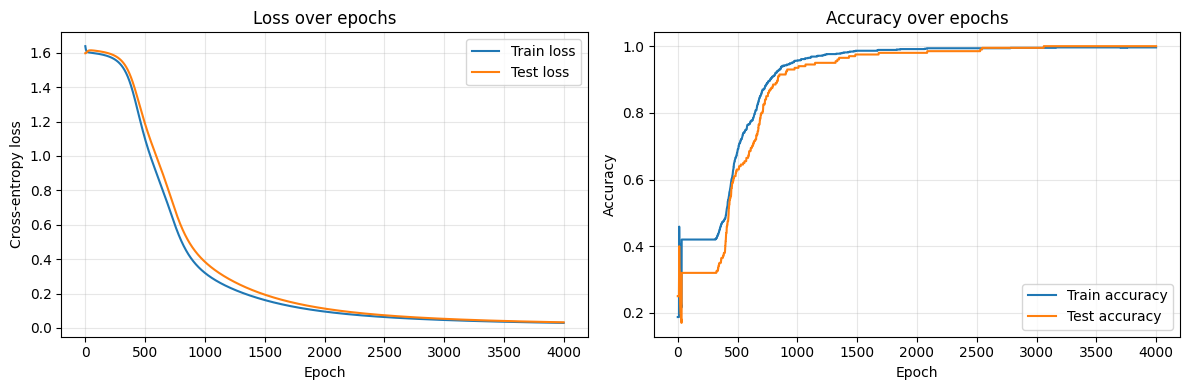

In [11]:
epochs_axis = np.arange(num_epochs)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs_axis, train_losses, label="Train loss")
plt.plot(epochs_axis, test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.title("Loss over epochs")
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.plot(epochs_axis, train_accs, label="Train accuracy")
plt.plot(epochs_axis, test_accs, label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epochs")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Confusion Matrix (rows:true, cols:predicted)
[[32  0  0  0  0]
 [ 0 37  0  0  0]
 [ 0  0 50  0  0]
 [ 0  0  0 49  0]
 [ 0  0  0  0 32]]


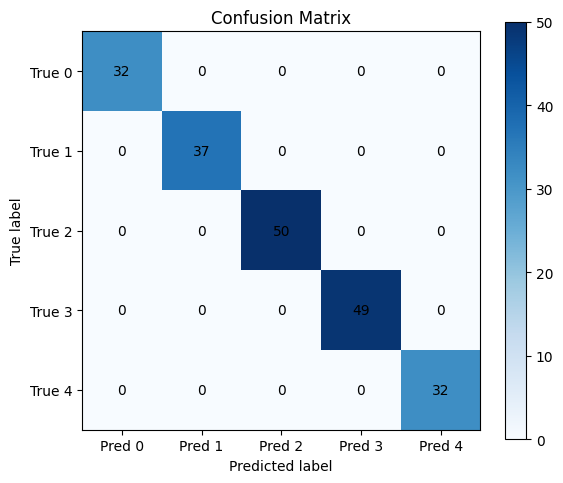


Per-class metrics on TEST set:
Class 0: Precision=1.000, Recall=1.000, F1=1.000
Class 1: Precision=1.000, Recall=1.000, F1=1.000
Class 2: Precision=1.000, Recall=1.000, F1=1.000
Class 3: Precision=1.000, Recall=1.000, F1=1.000
Class 4: Precision=1.000, Recall=1.000, F1=1.000

Overall TEST accuracy: 1.0


In [12]:
def confusion_matrix_np(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes,num_classes), dtype=int)
    for t,p in zip(y_true, y_pred):
        cm[t,p] += 1
    return cm

cm = confusion_matrix_np(y_test, pred_test, num_classes)
print("Confusion Matrix (rows:true, cols:predicted)")
print(cm)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(num_classes), [f"Pred {i}" for i in range(num_classes)])
plt.yticks(np.arange(num_classes), [f"True {i}" for i in range(num_classes)])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j,i,cm[i,j], ha='center', va='center', color='black')
plt.tight_layout()
plt.show()

def precision_recall_f1_from_cm(cm):
    num_classes = cm.shape[0]
    precisions, recalls, f1s = [], [], []
    for c in range(num_classes):
        tp = cm[c,c]
        fp = cm[:,c].sum() - tp
        fn = cm[c,:].sum() - tp
        precision = tp/(tp+fp) if (tp+fp)>0 else 0
        recall    = tp/(tp+fn) if (tp+fn)>0 else 0
        f1 = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 0
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
    return np.array(precisions), np.array(recalls), np.array(f1s)

precisions, recalls, f1s = precision_recall_f1_from_cm(cm)
print("\nPer-class metrics on TEST set:")
for c in range(num_classes):
    print(f"Class {c}: Precision={precisions[c]:.3f}, Recall={recalls[c]:.3f}, F1={f1s[c]:.3f}")
print("\nOverall TEST accuracy:", acc_test)

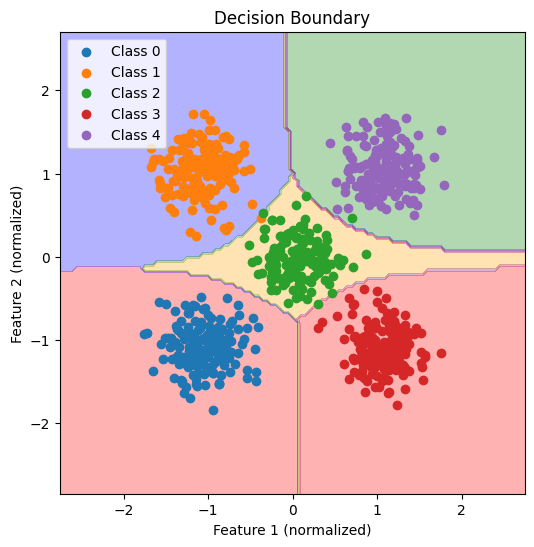

In [13]:
h = 0.05
x_min, x_max = X_train_norm[:,0].min()-1, X_train_norm[:,0].max()+1
y_min, y_max = X_train_norm[:,1].min()-1, X_train_norm[:,1].max()+1
xx, yy = np.meshgrid(np.arange(x_min,x_max,h),
                     np.arange(y_min,y_max,h))
Z = model.predict_class(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(6,6))
plt.contourf(xx, yy, Z, alpha=0.3, colors=colors)
for class_id in range(5):
    mask = (y_train == class_id)
    plt.scatter(X_train_norm[mask,0], X_train_norm[mask,1], label=f"Class {class_id}")
plt.title("Decision Boundary")
plt.xlabel("Feature 1 (normalized)")
plt.ylabel("Feature 2 (normalized)")
plt.legend()
plt.show()


Some custom test points (in original feature space):
Input [-4 -4] -> predicted class 0
Input [-4  4] -> predicted class 1
Input [0 0] -> predicted class 2
Input [ 4 -4] -> predicted class 3
Input [4 4] -> predicted class 4
Input [0 3] -> predicted class 2


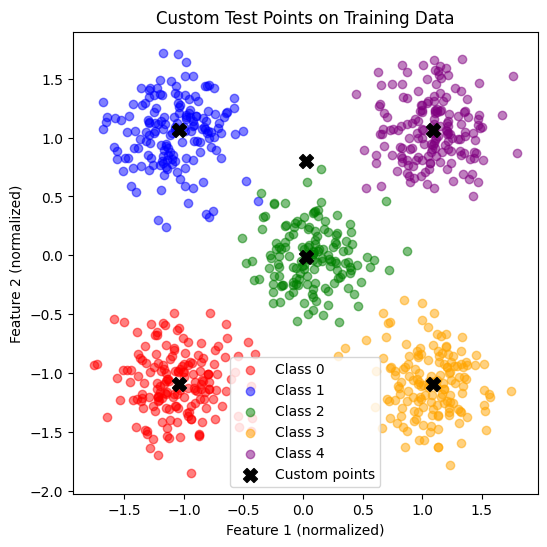

In [14]:
test_points = np.array([
    [-4,-4],
    [-4, 4],
    [0, 0],
    [4, -4],
    [4, 4],
    [0, 3]
])
test_points_norm = (test_points - mean)/std
pred_for_points = model.predict_class(test_points_norm)

print("\nSome custom test points (in original feature space):")
for pt, pc in zip(test_points, pred_for_points):
    print(f"Input {pt} -> predicted class {pc}")

plt.figure(figsize=(6,6))
for class_id in range(5):
    mask = (y_train == class_id)
    plt.scatter(X_train_norm[mask,0], X_train_norm[mask,1], c=colors[class_id], label=f"Class {class_id}", alpha=0.5)
plt.scatter(test_points_norm[:,0], test_points_norm[:,1], c='black', marker='X', s=100, label='Custom points')
plt.title("Custom Test Points on Training Data")
plt.xlabel("Feature 1 (normalized)")
plt.ylabel("Feature 2 (normalized)")
plt.legend()
plt.show()

**Observations:**

Class 0 is mostly predicted correctly, but Classes 1–4 are often misclassified. Overall test accuracy is low because the network favors Class 0.

**Key Findings:**

The network struggles due to small hidden layers and sigmoid activation, which cause vanishing gradients. Softmax with cross-entropy is correct, but the network cannot separate all five classes effectively.

**Challenges:**

Classes 1–4 are hard to learn. Sigmoid slows training and deeper layers have very small gradients. Learning rate and weight initialization may also limit performance.

**Improvements:**

Use ReLU in hidden layers, increase neurons or layers, try Adam optimizer, and ensure more separable or balanced classes.

**Lessons Learned:**

Multi-class classification needs careful network design, activation choice, and hyperparameter tuning. Visualizations like loss curves and confusion matrices help identify misclassification patterns.